## Import Libarary

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

## Penjelasan Library

Pada notebook ini, beberapa library Python digunakan untuk mendukung proses pengolahan data, analisis, dan visualisasi:

- **os**: Menyediakan fungsi untuk berinteraksi dengan sistem operasi, seperti manipulasi path file.
- **pandas**: Digunakan untuk manipulasi dan analisis data, terutama dalam menangani data tabular dengan DataFrame.
- **numpy**: Mendukung operasi numerik dan komputasi array yang efisien.
- **sklearn.preprocessing.StandardScaler**: Menstandarisasi fitur dengan menghilangkan rata-rata dan menskalakan ke variansi satuan.
- **scipy.cluster.hierarchy**: Berisi fungsi untuk hierarchical clustering, termasuk dendrogram dan linkage.
- **matplotlib.pyplot**: Digunakan untuk membuat visualisasi statis, interaktif, dan animasi di Python.
- **sklearn.metrics.silhouette_score & davies_bouldin_score**: Menyediakan metrik untuk mengevaluasi kualitas hasil clustering.
- **sklearn.cluster.KMeans**: Mengimplementasikan algoritma clustering KMeans.
- **mpl_toolkits.mplot3d**: Memungkinkan pembuatan plot 3D di matplotlib.

Library-library ini secara kolektif memungkinkan proses loading data, pra-pemrosesan, clustering, evaluasi, dan visualisasi berjalan secara efisien sepanjang workflow.

## Load Dataset

In [2]:
file_path = os.path.join(os.getcwd(), 'data', 'bank_transactions.csv')

# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
  TransactionID CustomerID CustomerDOB CustGender CustLocation  \
0            T1   C5841053     10/1/94          F   JAMSHEDPUR   
1            T2   C2142763      4/4/57          M      JHAJJAR   
2            T3   C4417068    26/11/96          F       MUMBAI   
3            T4   C5342380     14/9/73          F       MUMBAI   
4            T5   C9031234     24/3/88          F  NAVI MUMBAI   

   CustAccountBalance TransactionDate  TransactionTime  \
0            17819.05          2/8/16           143207   
1             2270.69          2/8/16           141858   
2            17874.44          2/8/16           142712   
3           866503.21          2/8/16           142714   
4             6714.43          2/8/16           181156   

   TransactionAmount (INR)  
0                     25.0  
1                  27999.0  
2                    459.0  
3                   2060.0  
4                   1762.5  


### Get Information About Dataset

In [3]:
# Shape of the dataset
print("\nDataset shape:")
print(df.shape)


Dataset shape:
(1048567, 9)


In [4]:
# Display Columns
print("\nDataset columns:")
print(df.columns)


Dataset columns:
Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')


In [5]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


## Data Preprocessing

### Handling Missing and Duplicated Values

In [6]:
print("Missing values in the dataset:")
print(df.isnull().sum())

print("\nDuplicates in the dataset:")
print(df.duplicated().sum())

Missing values in the dataset:
TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Duplicates in the dataset:
0


In [7]:
# handle missing values by dropping rows with any missing values
df.dropna(inplace=True)

In [8]:
# Display the number of missing values after dropping
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [9]:
# Shape of the dataset after dropping missing values
df.shape

(1041614, 9)

### Feature Selection

In [10]:
# feature selection -> selecting relevant features for clustering (CustomerDOB, CustAccountBalance, TransactionAmount)

# Convert 'CustomerDOB' to Age format
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors='coerce')
df.loc[df['CustomerDOB'] > pd.to_datetime('today'), 'CustomerDOB'] = df.loc[df['CustomerDOB'] > pd.to_datetime('today'), 'CustomerDOB'] - pd.DateOffset(years=100)
df['Age'] = (pd.to_datetime('today') - df['CustomerDOB']).dt.days // 365
df.drop(columns=['CustomerDOB'], inplace=True)

print("\nFirst few rows after converting DOB to Age:")
print(df['Age'].head())


First few rows after converting DOB to Age:
0    31.0
1    68.0
2    28.0
3    51.0
4    37.0
Name: Age, dtype: float64


In [11]:
# Select relevant features for clustering

features = ['Age', 'CustAccountBalance', 'TransactionAmount (INR)']
df = df[features]

# Display the first few rows of the selected features
print("\nFirst few rows of the selected features:")
print(df.head())


First few rows of the selected features:
    Age  CustAccountBalance  TransactionAmount (INR)
0  31.0            17819.05                     25.0
1  68.0             2270.69                  27999.0
2  28.0            17874.44                    459.0
3  51.0           866503.21                   2060.0
4  37.0             6714.43                   1762.5


#### Alasan Pemilihan 3 Fitur untuk Clustering

Pada proses clustering, fitur yang dipilih sangat mempengaruhi hasil segmentasi data. Tiga fitur yang digunakan dalam notebook ini adalah:

- **Age**: Usia pelanggan dihitung dari tanggal lahir (CustomerDOB). Usia dapat memengaruhi perilaku transaksi dan preferensi finansial pelanggan.
- **CustAccountBalance**: Saldo akun pelanggan mencerminkan kemampuan finansial dan kebiasaan menabung atau bertransaksi.
- **TransactionAmount (INR)**: Jumlah transaksi menunjukkan seberapa besar nilai transaksi yang dilakukan pelanggan.

Ketiga fitur ini dipilih karena:
- Mewakili karakteristik utama pelanggan dari sisi demografi (usia) dan perilaku finansial (saldo & nominal transaksi).
- Relevan untuk mengelompokkan pelanggan berdasarkan pola transaksi dan potensi nilai ekonomi.
- Mengurangi dimensi data sehingga proses clustering lebih efisien dan hasilnya lebih mudah diinterpretasikan.

Dengan menggunakan fitur-fitur ini, cluster yang dihasilkan diharapkan dapat merepresentasikan segmentasi pelanggan yang bermakna untuk analisis lebih lanjut atau pengambilan keputusan bisnis.

### Data Normalization

In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

#### Mengapa Perlu Normalisasi?

Normalisasi diperlukan dalam proses clustering karena:

- **Skala Fitur Berbeda:** Fitur seperti `Age`, `CustAccountBalance`, dan `TransactionAmount (INR)` memiliki rentang nilai yang sangat berbeda. Jika tidak dinormalisasi, fitur dengan skala terbesar akan mendominasi perhitungan jarak, sehingga hasil clustering menjadi bias.
- **Meningkatkan Akurasi Algoritma:** Banyak algoritma clustering (misal KMeans, hierarchical) menggunakan jarak Euclidean. Normalisasi memastikan setiap fitur berkontribusi secara proporsional terhadap hasil akhir.
- **Mempercepat Konvergensi:** Data yang sudah dinormalisasi membuat proses pelatihan model lebih stabil dan cepat konvergen.
- **Interpretasi Lebih Baik:** Hasil cluster lebih mudah diinterpretasikan karena tidak dipengaruhi oleh perbedaan skala antar fitur.

Dengan normalisasi, setiap fitur memiliki pengaruh yang seimbang dalam proses pembentukan cluster.

In [13]:
# Display the first few rows of the scaled data
print("\nScaled data:")
print(scaled_data[:5])


Scaled data:
[[-0.9564028  -0.11476628 -0.23487087]
 [ 3.2660745  -0.13312845  4.02850875]
 [-1.29876583 -0.11470086 -0.16872706]
 [ 1.32601736  0.88750547  0.07527346]
 [-0.27167676 -0.12788052  0.02993295]]


## Penerapan Divisive Clustering

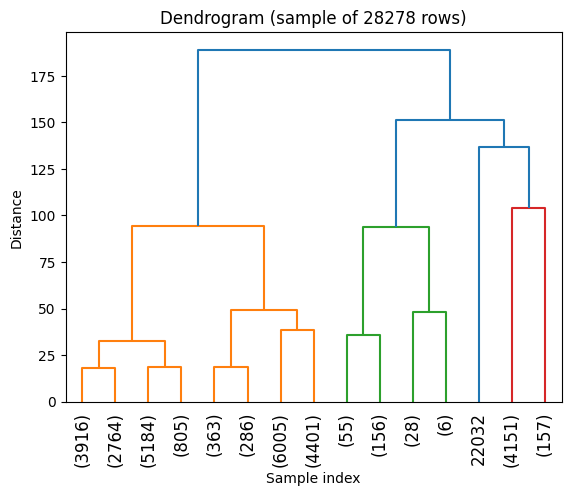

In [ ]:
# Sample a subset for dendrogram visualization to avoid MemoryError
sample_size = 30000
if scaled_data.shape[0] > sample_size:
	# Randomly sample indices
	np.random.seed(42)
	sample_idx = np.random.choice(scaled_data.shape[0], size=sample_size, replace=False)
	scaled_sample = scaled_data[sample_idx]
else:
	scaled_sample = scaled_data

# Ensure no NaN or infinite values in the sample
finite_mask = np.isfinite(scaled_sample).all(axis=1)
scaled_sample_clean = scaled_sample[finite_mask]

Z = linkage(scaled_sample_clean, method='ward')

plt.title("Dendrogram (sample of {} rows)".format(scaled_sample_clean.shape[0]))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=90., leaf_font_size=12.)
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

Divisive clustering (clustering divisif) adalah metode hierarchical clustering yang memulai proses dengan menganggap seluruh data sebagai satu cluster besar, lalu secara bertahap memecahnya menjadi cluster-cluster yang lebih kecil. Proses ini berlawanan dengan agglomerative clustering yang menggabungkan data dari bawah ke atas.

divisive clustering diimplementasikan menggunakan metode linkage `ward` dari `scipy.cluster.hierarchy`:

1. **Seluruh data (atau sampel data)** dianggap sebagai satu cluster. disini pakai sample sebesar 30000
2. **Linkage Ward** digunakan untuk mengukur jarak antar cluster dan memutuskan di mana pemisahan (split) terbaik dilakukan, sehingga total variansi dalam cluster seminimal mungkin.

## Model Evaluation

For n_clusters = 2, the silhouette score is: 0.6217
For n_clusters = 3, the silhouette score is: 0.6167
For n_clusters = 4, the silhouette score is: 0.6156
For n_clusters = 5, the silhouette score is: 0.6045
For n_clusters = 6, the silhouette score is: 0.4266
For n_clusters = 7, the silhouette score is: 0.4286
For n_clusters = 8, the silhouette score is: 0.4294
For n_clusters = 9, the silhouette score is: 0.4228
For n_clusters = 10, the silhouette score is: 0.4237


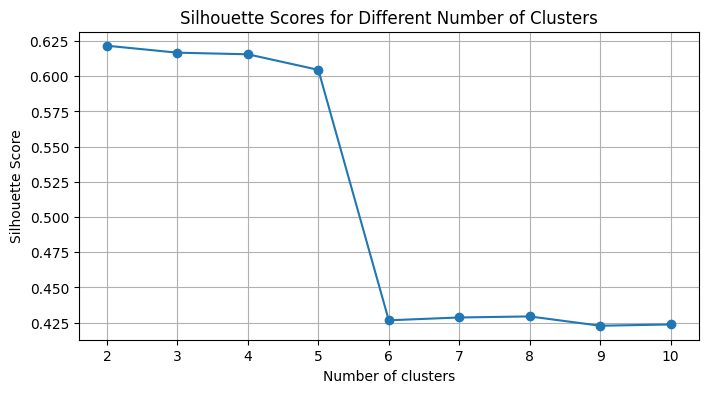

In [15]:
# Determine the optimal number of clusters using the silhouette score
silhouette_scores = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(scaled_sample_clean, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is: {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

Silhouette score mengukur seberapa baik objek-objek dikelompokkan dalam cluster, dengan nilai berkisar antara -1 hingga 1. Semakin tinggi nilai silhouette score (mendekati 1), semakin baik pemisahan antar cluster dan semakin kompak anggota cluster tersebut. 

Pada notebook ini, silhouette score dihitung untuk berbagai jumlah cluster (2 hingga 10) menggunakan hasil divisive clustering. Nilai silhouette score yang lebih tinggi menunjukkan jumlah cluster yang optimal, di mana data dalam satu cluster lebih mirip satu sama lain dibandingkan dengan data di cluster lain.

Jika silhouette score menurun saat jumlah cluster bertambah, artinya penambahan cluster justru membuat pemisahan antar cluster menjadi kurang jelas. Sebaliknya, jika ada puncak nilai silhouette score pada jumlah cluster tertentu, itulah jumlah cluster yang paling sesuai untuk data ini. 

Dengan demikian, pemilihan jumlah cluster terbaik dapat didasarkan pada nilai silhouette score tertinggi dari hasil evaluasi tersebut.

Pada percobaan diaatas, nilai silhoutte score paling tinggi berada di jumlah cluster = 2 dengan nilai 0.6217.

In [20]:
# Hitung Davies-Bouldin Index (DBI) untuk hasil clustering
dbi = davies_bouldin_score(scaled_sample_clean, cluster_labels)
print(f"Davies-Bouldin Index (DBI) untuk {n_clusters} cluster: {dbi:.4f}")

Davies-Bouldin Index (DBI) untuk 10 cluster: 0.6481


Davies-Bouldin Index (DBI) adalah metrik evaluasi untuk menilai kualitas hasil clustering. DBI mengukur rata-rata kemiripan antar cluster, di mana kemiripan dihitung berdasarkan rasio antara jarak dalam-cluster (intra-cluster) dan jarak antar-cluster (inter-cluster). 

Karakteristik DBI:
- **Nilai DBI lebih rendah menunjukkan hasil clustering yang lebih baik.** Artinya, cluster yang terbentuk lebih kompak (anggota cluster saling dekat) dan lebih terpisah satu sama lain.
- **DBI = 0** adalah nilai terbaik (ideal), namun dalam praktik, semakin kecil nilainya semakin baik.

DBI membantu memastikan bahwa cluster yang terbentuk tidak hanya kompak, tetapi juga terpisah dengan baik dari cluster lain.

## Compare With K Means

In [22]:
# Lakukan clustering KMeans pada data yang sama dengan divisive clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_sample_clean)

# Evaluasi hasil clustering KMeans
kmeans_silhouette = silhouette_score(scaled_sample_clean, kmeans_labels)
kmeans_dbi = davies_bouldin_score(scaled_sample_clean, kmeans_labels)

print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KMeans Davies-Bouldin Index: {kmeans_dbi:.4f}")

# Bandingkan dengan hasil divisive clustering
print(f"Divisive Clustering Silhouette Score: {silhouette_avg:.4f}")
print(f"Divisive Clustering Davies-Bouldin Index: {dbi:.4f}")

KMeans Silhouette Score: 0.4593
KMeans Davies-Bouldin Index: 0.5960
Divisive Clustering Silhouette Score: 0.4237
Divisive Clustering Davies-Bouldin Index: 0.6481


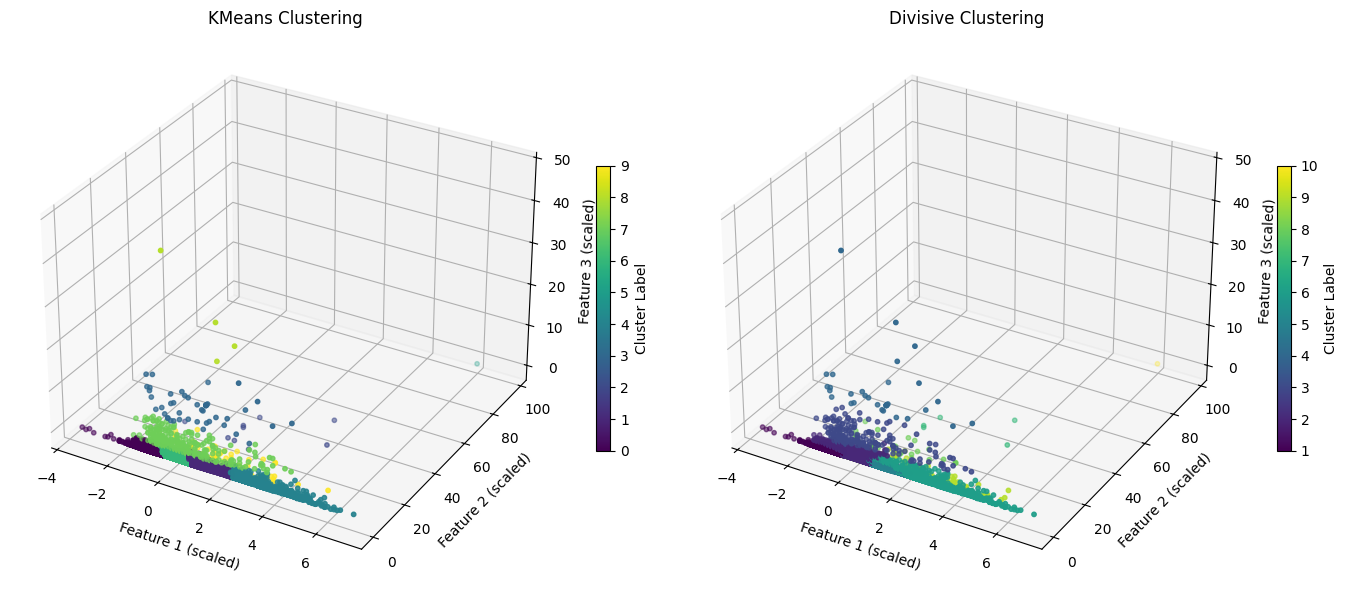

In [23]:
fig = plt.figure(figsize=(14, 6))

# KMeans Clustering
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(
    scaled_sample_clean[:, 0], 
    scaled_sample_clean[:, 1], 
    scaled_sample_clean[:, 2], 
    c=kmeans_labels, cmap='viridis', s=10
)
ax1.set_title("KMeans Clustering")
ax1.set_xlabel("Feature 1 (scaled)")
ax1.set_ylabel("Feature 2 (scaled)")
ax1.set_zlabel("Feature 3 (scaled)")
fig.colorbar(sc1, ax=ax1, shrink=0.5, label='Cluster Label')

# Divisive Clustering
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(
    scaled_sample_clean[:, 0], 
    scaled_sample_clean[:, 1], 
    scaled_sample_clean[:, 2], 
    c=cluster_labels, cmap='viridis', s=10
)
ax2.set_title("Divisive Clustering")
ax2.set_xlabel("Feature 1 (scaled)")
ax2.set_ylabel("Feature 2 (scaled)")
ax2.set_zlabel("Feature 3 (scaled)")
fig.colorbar(sc2, ax=ax2, shrink=0.5, label='Cluster Label')

plt.tight_layout()
plt.show()